In [20]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy.interpolate import interp1d
from torch.utils.data import Dataset
from torch import tensor
from tqdm import tqdm
import torch

# Dataset

In [49]:
# Folder name will correspond to index of sample
curves = []

def getCurves(runs, signalFolder="D:/SamplingResults2"):
    for run in tqdm(runs): #os.listdir(f"{signalFolder}/"):  
        fail = False
        probes = []

        files = os.listdir(f"{signalFolder}/{run}/")

        if files != ['Disp1.csv', 'Disp2.csv']:
            continue

        for file in files:
            a = pd.read_csv(f"{signalFolder}/{run}/{file}")
            a.rename(columns = {'0':'x', '0.1': 'y'}, inplace = True)

            if a['x'].max() != 7.0:
                fail = True
                break
            probes.append(a)
        if not fail:
            if len(probes) != 2:
                raise Exception("sdf")

            curves.append(probes)
    return curves
    

In [50]:
with open("../Data/filtered.pkl", "rb") as f:
    runs = pickle.load(f)

In [51]:
curves = getCurves(runs)

100%|█████████████████████████████████████████████████████████████████████████████| 2241/2241 [00:08<00:00, 262.83it/s]


In [478]:
c = curves[0][0]

In [479]:
c

,x,y
0,0.005000,0.000000
1,0.011000,0.000125
2,0.017800,0.000322
3,0.025240,0.000580
4,0.033192,0.000886
...,...,...
706,6.961142,-0.000053
707,6.971062,-0.000053
708,6.980997,-0.000053
709,6.990945,-0.000053


[3, 90, 92, 100]


C:\Users\rjsou\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\rjsou\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


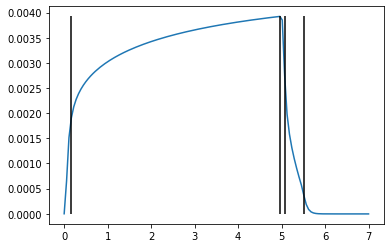

In [484]:
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d

fig, ax = plt.subplots(1, 1)
xNew = np.linspace(0, 7, num=128, endpoint=True)
interped = interp1d(c['x'], c['y'], kind='cubic', fill_value="extrapolate")(xNew)

ax.plot(xNew, interped)

gs = np.gradient(interped)
diffs = []
ind = []

# Find suction gradient changes
for i in range(1, len(gs)):
    diff = abs(gs[i]-gs[i-1])
    if i == 1:
        continue
    if len(ind) > 1:
        break
    if diff > np.mean(diffs)*1.25:
        ind.append(i)
        diffs = []
    else:
        diffs.append(diff)

ymax = interped.max()
found = False
idx = 0
for i in range(len(interped)):
    if found == True:
        if interped[i] < ymax:
            idx = i-1
            break
    elif interped[i] == ymax:
        found = True

end_phase = False
for i in range(idx+1, len(gs)-1):
    diff = abs(gs[i]-gs[i+1])

    if len(ind) > 4:
        break
        
    if diff > np.mean(diffs)/1.5 and  i - ind[-1] > 0:
        ind.append(i)
        diffs = []
    else:
        diffs.append(diff)
        
        

print(ind)
ax.vlines(xNew[ind], min(c['y']), max(c['y']), colors="black")
#ax.vlines(xNew[idx], min(c['y']), max(c['y']), colors="red")

In [481]:
def piecewise_interpolation(curve, num_points=5, threshold=0.00001):
    """
    Performs piecewise interpolation of a curve by identifying points at which the gradient changes significantly.

    Args:
        curve (np.ndarray): Array containing the curve to be interpolated.
        num_points (int): Number of points to be identified on the curve.
        threshold (float): Threshold value for detecting significant changes in the gradient.

    Returns:
        List of indices representing the identified points on the curve.
    """
    indices = [0]  # start with the first point

    # Calculate the gradient between each point and compare against the threshold to identify significant changes
    grad = np.gradient(curve)
    phase_step = 30
    max_y = np.argmax(curve)
    #print(max_y)
    #max_y = max(np.argwhere(curve == curve[idx]))
    #print(max_y)
    
    
    end_phase = False
    for i in range(1, len(curve)):
        if end_phase and i < max_y:
            continue
            
        if end_phase:
            print(max_y)
       
        if abs(grad[i] - grad[indices[-1]]) > threshold:
            if i - indices[-1] < phase_step:
                continue
            indices.append(i)
            
        if len(indices) > 2:
            end_phase = True
            # Move to end of suction phase
                
            if len(indices) == num_points:  # exit early if all points have been identified
                break
    
    return indices[1:]

501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
[113, 501, 531, 561]
113    1.115
501    4.995
531    5.295
561    5.595
Name: x, dtype: float64


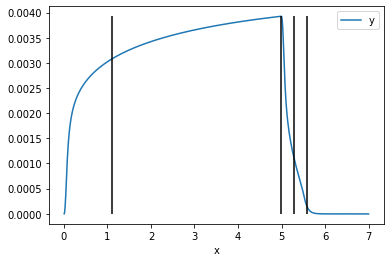

In [482]:
c = curves[50][1]
new = piecewise_interpolation(c['y'])
print(new)
new = c['x'][new]
print(new)
fig, ax = plt.subplots(1, 1)
c.plot(x='x', y='y', ax=ax)
ax.vlines(new, min(c['y']), max(c['y']), colors="black")

In [426]:
a = np.array([3, 3, 3, 5, 6, 2, 6])
b = np.argmax(a)
max(np.where(a[b] == a))

array([4, 6], dtype=int64)